__1__:<br>
VAE-VQ offers several advantages over traditional VAEs:

Discrete Latent Representations: VAE-VQ introduces discrete latent variables using vector quantization, allowing the model to capture and utilize categorical information in the latent space. This is particularly beneficial when dealing with data with clear categorical variations.

Meaningful Exploration in Latent Space: The discrete latent variables in VAE-VQ provide a more meaningful latent space. Each discrete code corresponds to a specific category or mode, making it easier to navigate and understand the latent representations.

Improved Generative Capabilities: By incorporating vector quantization, VAE-VQ improves the generative capabilities of the model. The discrete latent variables enable more controlled and targeted generation of samples, making it suitable for tasks.

Addressing Mode Collapse: VAE-VQ's training strategy, involving commitment loss and Vector Quantization, helps address issues like mode collapse, where the model fails to represent the full diversity of the data. The commitment loss encourages the encoder to commit to specific embeddings.

Effective Handling of Categorical Data: VAE-VQ is well-suited for scenarios where the data exhibits categorical variations, such as different styles, classes, or modes. Traditional VAEs may struggle with capturing these discrete variations effectively.

Applicability to Various Domains: VAE-VQ demonstrates versatility in handling different types of data, including images, speech, and videos. The model's ability to extract 1D, 2D, or 3D latent feature spaces makes it adaptable to a wide range of applications.

Training Stability: The training strategy of VAE-VQ, involving the straight-through estimator and the use of a dedicated loss term for embedding updates, contributes to stable training and better convergence.

In [86]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

__2__:

In [88]:
training_data = datasets.MNIST(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor()
                                  ]))

validation_data = datasets.MNIST(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor()
                                  ]))


In [89]:
batch_size = 128

training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

__3__ & __4__ & __5__:

In [90]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        flat_input = inputs.view(-1, self._embedding_dim)

        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [91]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [92]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [93]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=1,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

In [94]:
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 2
num_embeddings = 3

commitment_cost = 0.25

learning_rate = 1e-3

In [96]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost):
        super(Model, self).__init__()

        self._encoder = Encoder(1, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)

        self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [97]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost).to(device)

__6__:

In [98]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [99]:
errors = []
num_epochs = 20
model.train()
train_res_recon_error = []
train_res_perplexity = []

for epoch in range(num_epochs):
    for data_label in training_loader:
      data, _ = data_label
      data = data.to(device)
      optimizer.zero_grad()

      vq_loss, data_recon, perplexity = model(data)

      recon_error = F.mse_loss(data_recon, data)
      loss = recon_error + vq_loss
      loss.backward()

      optimizer.step()

      train_res_recon_error.append(recon_error.item())
      train_res_perplexity.append(perplexity.item())

    print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
    errors.append(np.mean(train_res_recon_error[-100:]))
    print()

recon_error: 0.019

recon_error: 0.016

recon_error: 0.015

recon_error: 0.014

recon_error: 0.014

recon_error: 0.014

recon_error: 0.014

recon_error: 0.014

recon_error: 0.013

recon_error: 0.013

recon_error: 0.013

recon_error: 0.013

recon_error: 0.013

recon_error: 0.013

recon_error: 0.013

recon_error: 0.013

recon_error: 0.013

recon_error: 0.013

recon_error: 0.013

recon_error: 0.013



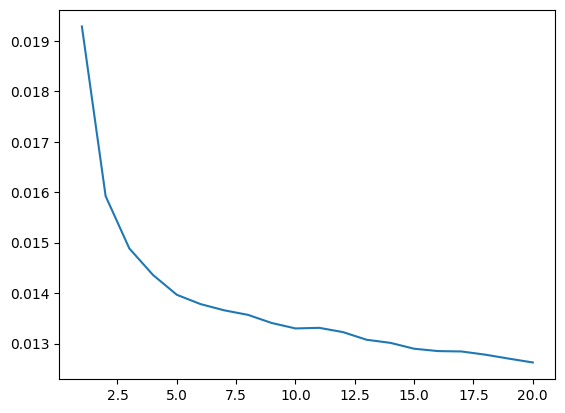

In [100]:
x = list(range(1, 21))
plt.plot(x, errors)